### Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import requests
import datetime as dt
from warnings import simplefilter # ignore all future warnings
from __future__ import print_function
import pickle

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,  ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, label_binarize
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, make_scorer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import xgboost as xgb

simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

##  Choosing A Model and Target Metric

The goal of this analysis is to find out what songs will be hits and to find the best model for that.  That said, when looking at how these models could be used, I think the best metric will be ROC AUC for practical use.  Part of the reason is how this data set looks in general with class balance skewing things from how many hits actually happen in reality.  I am still interested in the model's accuracy of predicting a hit, but this is secondary to finding the best song possible, even the best of the hits.

From a business perspective, every album, album and label is faced with the dilemma of what song is most likely to be a hit and impact the most number of people (ok artist may have more pure intentions, but you get my drift). Many of the decisions of which song to release first or ahead of an album release would benefit from this analysis as a really good song can generate interest and revenues. 

When it comes time for a label to invest studio and marketing time into an artist they want to do so with the highest change of success.  So by ranking and using the probabilities of ROC AUC we will have a pecking order by song for song qualities measurements we think will make a hit most realistic

### Metric Goal : ROC AUC


### Import Data

In [2]:
#tunez= pd.read_pickle('mill.pickle')
tunez = pd.read_pickle('tunes.pickle')
tunez

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,target,decade,prev_hits,hiphop,pop,rock,techno,jazz,soul_blues,genre_class
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.4900,0.000000,...,1,1960,0,0,0,0,0,0,1,Soul_Blues
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,...,0,1960,0,0,1,1,0,0,0,Rock_Pop
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.8460,0.000004,...,0,1960,0,0,0,0,0,0,0,Other
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.7060,0.024600,...,0,1960,0,0,0,0,0,1,0,Jazz
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.8570,0.000872,...,0,1960,0,0,0,0,0,0,0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,Lotus Flowers,Yolta,0.172,0.358,9,-14.430,1,0.0342,0.8860,0.966000,...,0,2010,0,0,0,0,0,0,0,Other
41102,Calling My Spirit,Kodak Black,0.910,0.366,1,-9.954,1,0.0941,0.0996,0.000000,...,1,2010,8,1,0,0,0,0,0,Hip_Hop_RB
41103,Teenage Dream,Katy Perry,0.719,0.804,10,-4.581,1,0.0355,0.0132,0.000003,...,1,2010,21,0,1,0,0,0,0,Pop
41104,Stormy Weather,Oscar Peterson,0.600,0.177,7,-16.070,1,0.0561,0.9890,0.868000,...,0,2010,0,0,0,0,0,1,0,Jazz


### Train, Val, Test  Split - No Engineered Features

As promised, let's start with the data purely out of the original files with only Spotify song features and the decade they were created in.  We will compare the results across models and then add in previous hits and genres to see which performs better

In [3]:
#Create columns list to split with target, will look at genre dummy genre variables and previous hits after an initial run
xs = ['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'decade']

In [4]:
# create X (features) and y (response)
X = tunez.loc[:,xs]
y = tunez['target']

In [5]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=2)

In [6]:
# print the shapes of the new X objects
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24663, 16)
(8221, 16)
(8222, 16)


In [7]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(24663,)
(8221,)
(8222,)


In [8]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
X_val_scaled = std.fit_transform(X_val)
X_test_scaled = std.fit_transform(X_test)
X_scaled = std.fit_transform(X_tr)

## Dummy Classifier

Just using the most frequent guess we see we get about ~50% correct for our data set

In [9]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_val)
dummy_clf.score(X_val, y_val)

0.4938571949884442

## KNN 

First let's look for the ideal number of neigbors for K Nearest neighbor and then we can attemps cross validation vs regular KNN

In [10]:
k_range = list(range(1, 41))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y_tr, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.7147547602085844, 0.6985459623947405, 0.7421236847887118, 0.7361027671683018, 0.751125137688927, 0.7530108564343727, 0.7558387132807951, 0.7573592373457496, 0.757693842706537, 0.7609781351093633, 0.7595183458242805, 0.7646577861469959, 0.7606131253703453, 0.7639278961279914, 0.758727758013699, 0.7623162421520085, 0.7591534193089255, 0.7624377487000464, 0.759305431953004, 0.7625897983324197, 0.7592447619026483, 0.7627115268102257, 0.7596704879273904, 0.7621033097865849, 0.7579674451223166, 0.7612518669841742, 0.7576329507264131, 0.7611301107651474, 0.7570550363631925, 0.7613429136715395, 0.7572983916009941, 0.7603698256149858, 0.7570550271161187, 0.759366185227023, 0.7560211395501779, 0.7588189064188746, 0.7555040801787866, 0.7572680519522791, 0.7556256884446347, 0.7572679224932478]


Text(0, 0.5, 'Cross-Validated Accuracy')

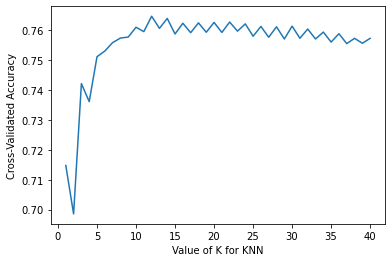

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Ok great somewhere in the 10 to 15 region looks about right for the number of neighbors.  We will roll with 10 and take a look at the cross val KNN first

In [12]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X_scaled, y_tr, cv=10, scoring='accuracy')
print(scores)

[0.75007601 0.76375798 0.76132563 0.76375798 0.76307786 0.75881995
 0.76368613 0.763382   0.75547445 0.76642336]


In [13]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.7609781351093633


In [14]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_val_scaled)
print("Training set: ", knn.score(X_train_scaled, y_train))
print("Validation set: ", knn.score(X_val_scaled, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.8025787617078214
Validation set:  0.7584235494465393
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      4161
           1       0.72      0.84      0.78      4060

    accuracy                           0.76      8221
   macro avg       0.77      0.76      0.76      8221
weighted avg       0.77      0.76      0.76      8221



Cross validation and train vs val appear to do about the same on accuracy, let's take a look at the confusion matric and ROC AUC rom the train/val model

In [142]:
def confusion(y_val, y_pred, model_name):
    plt.figure(figsize=(15, 15))
    conf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(conf_matrix, annot=True, square=True, cmap=plt.cm.Blues, fmt='d',
           xticklabels=['flop', 'hit'],
           yticklabels=['flop', 'hit'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("{} Confusion Matrix".format(model_name),fontweight="bold");

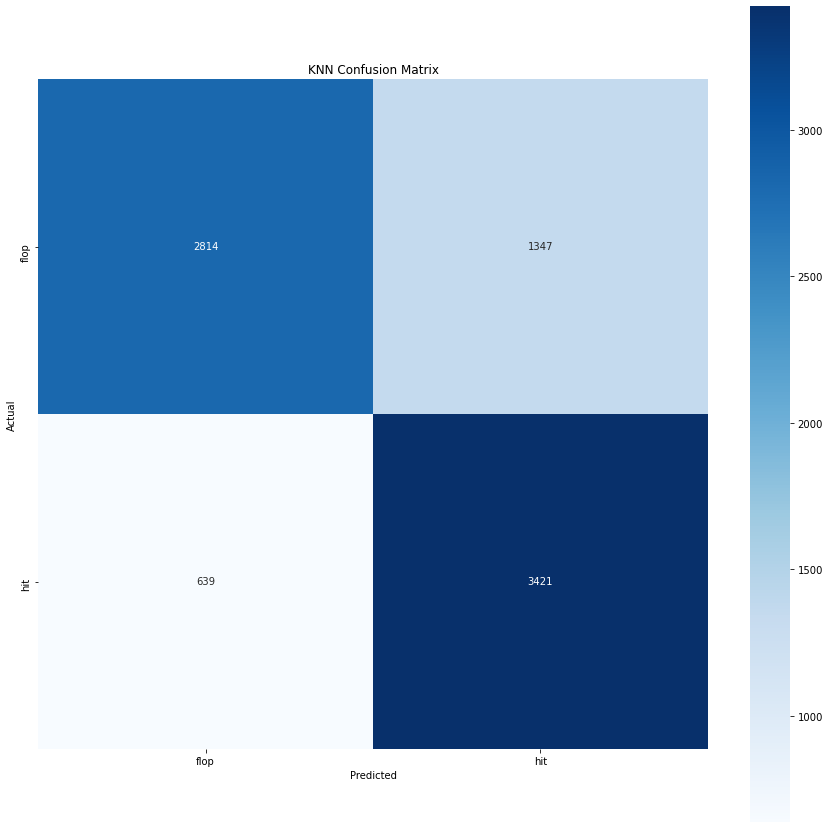

In [16]:
confusion(y_val, y_pred, "KNN")

Looks like we're overpredicting our hits in our knn

Default threshold:
Precision: 0.7175,   Recall: 0.8426
ROC AUC score =  0.8276038762470654


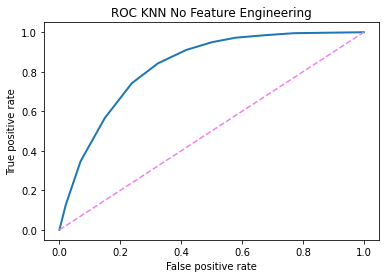

In [17]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC KNN No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))

## Logistic Regression

In [24]:
log_reg = LogisticRegression(max_iter=2000,C=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_val_scaled)
print("Training set: ", log_reg.score(X_train_scaled, y_train))
print("Validation set: ", log_reg.score(X_val_scaled, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.743380772817581
Validation set:  0.7349470867291084
              precision    recall  f1-score   support

           0       0.79      0.65      0.71      4161
           1       0.70      0.82      0.75      4060

    accuracy                           0.73      8221
   macro avg       0.74      0.74      0.73      8221
weighted avg       0.74      0.73      0.73      8221



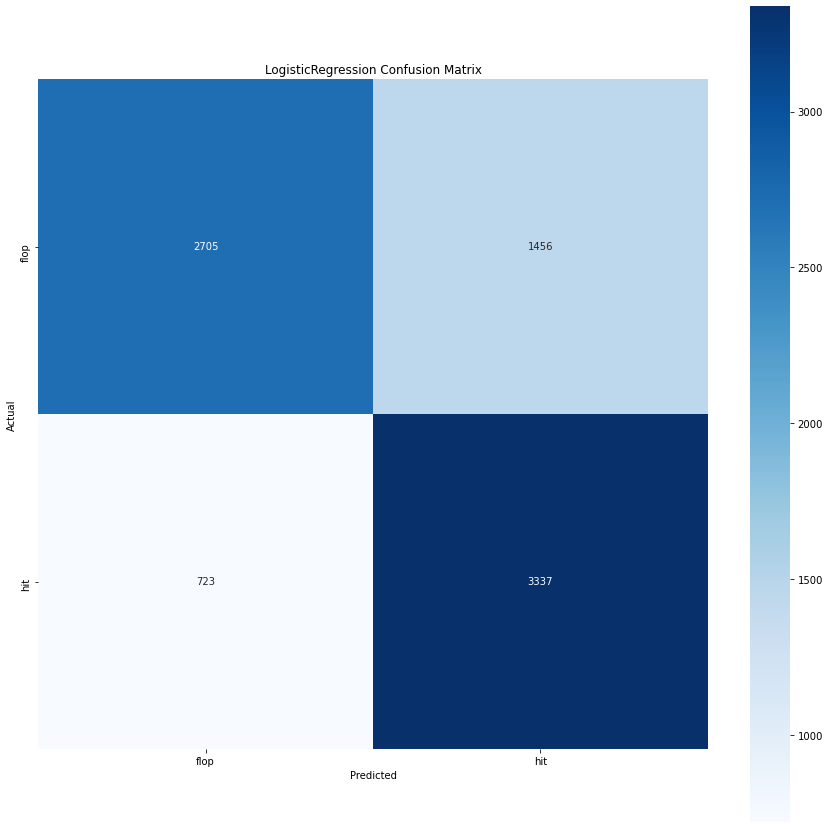

In [25]:
confusion(y_val, y_pred, "LogisticRegression")

Accuracy for logistic regression performs slightly worse recall for targets while accuracy it appears to be about the same, but it scores similarly on train and validation sets.

In [26]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, log_reg.predict_proba(X_val_scaled)[:,1])

Default threshold:
Precision: 0.6962,   Recall: 0.8219


ROC AUC score =  0.8074803802136423


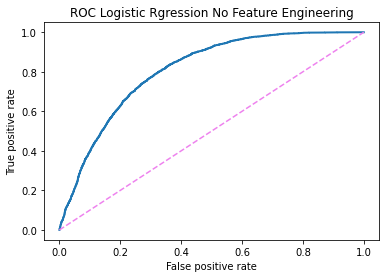

In [27]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Logistic Rgression No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1]))

Looked at various C's (1,100,1000) with minimal impact on performancce from an accuracy perspective.  While we could adjust threshold to look at precision and recall impact, our primary metric of ROC AUC will not be influence by this so for now Logisitic Regression is actually scoring slightly worse than KNN.

### Random Forrest No Feature Engineering

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=300, max_depth=50) 
rf_model = rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

In [29]:
print("Training set: ", rf_model.score(X_train, y_train))
print("Validation set: ", rf_model.score(X_val, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.9996350808904026
Validation set:  0.8040384381462109
              precision    recall  f1-score   support

           0       0.85      0.75      0.79      4161
           1       0.77      0.86      0.81      4060

    accuracy                           0.80      8221
   macro avg       0.81      0.80      0.80      8221
weighted avg       0.81      0.80      0.80      8221



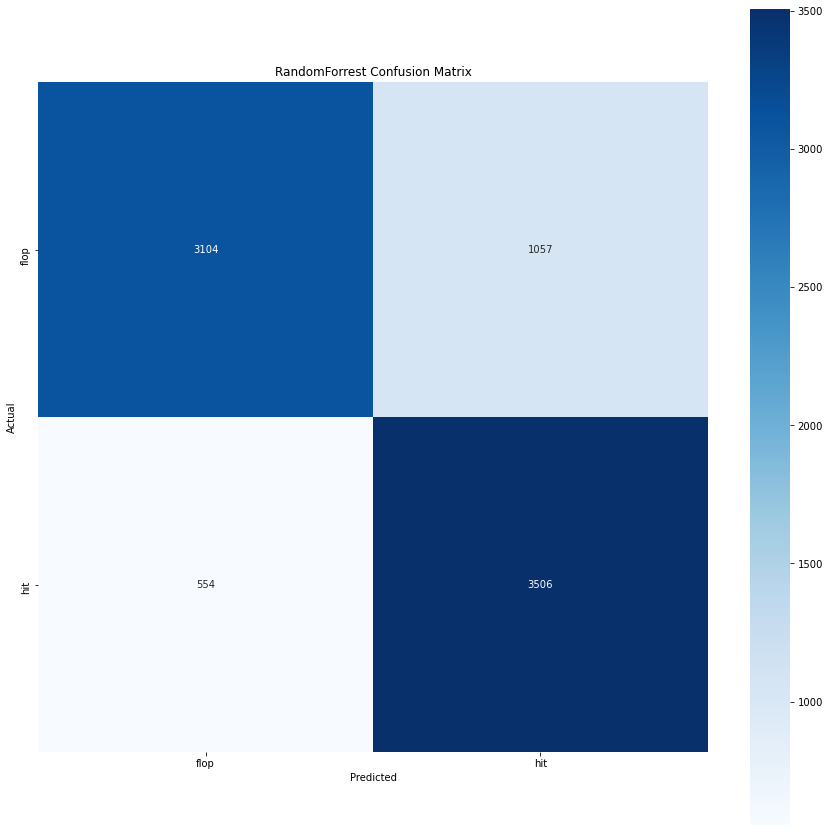

In [30]:
confusion(y_val, y_pred, "RandomForrest")

Default threshold:
Precision: 0.7684,   Recall: 0.8635
ROC AUC score =  0.8815496168385063


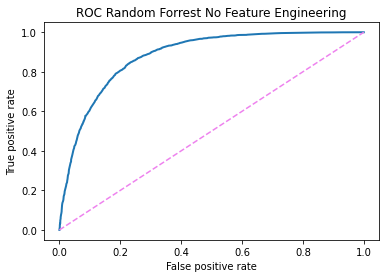

In [31]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Random Forrest No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, rf_model.predict_proba(X_val)[:,1]))

AH HA! Our best ROC AUC score yet at .8815 and our highest score on accurately predicting hits at .80. We are still overpredicting hits with this model. Let's look at XGB Boost. 

### XG Boost No Feature Enegineering

In [33]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=8,
                        objective='binary:logistic', 
                        learning_rate=.2, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
#fit_model_n = no feature enegineering
fit_model_n = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', 
                    early_stopping_rounds=50,
                    verbose=False
                   )
y_pred = fit_model_n.predict(X_val)
accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)) 

0.8058630336941978

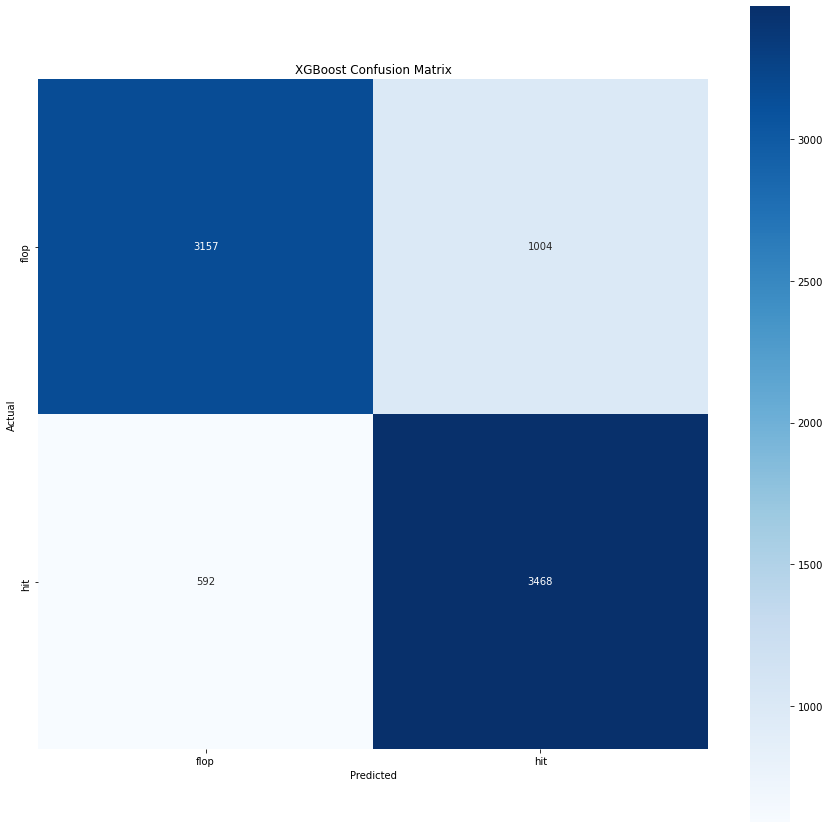

In [34]:
confusion(y_val, y_pred, "XGBoost")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

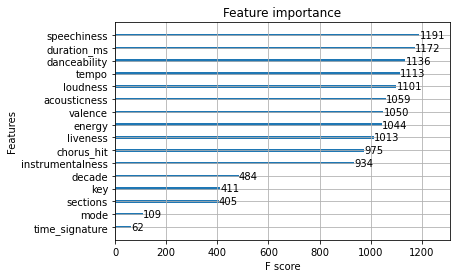

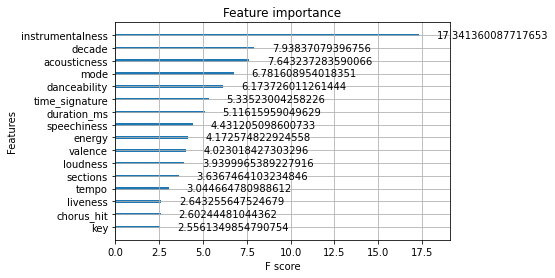

In [35]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

In [36]:
gbm.get_booster().get_score(importance_type='weight') #extract raw frequency scores

{'instrumentalness': 934,
 'acousticness': 1059,
 'energy': 1044,
 'duration_ms': 1172,
 'decade': 484,
 'speechiness': 1191,
 'sections': 405,
 'mode': 109,
 'valence': 1050,
 'liveness': 1013,
 'loudness': 1101,
 'time_signature': 62,
 'danceability': 1136,
 'tempo': 1113,
 'key': 411,
 'chorus_hit': 975}

In [37]:
gbm.get_booster().get_score(importance_type='gain') #extract raw gain scores

{'instrumentalness': 17.341360087717653,
 'acousticness': 7.643237283590066,
 'energy': 4.172574822924558,
 'duration_ms': 5.11615959049629,
 'decade': 7.93837079396756,
 'speechiness': 4.431205098600733,
 'sections': 3.6367464103234846,
 'mode': 6.781608954018351,
 'valence': 4.023018427303296,
 'liveness': 2.643255647524679,
 'loudness': 3.9399965389227916,
 'time_signature': 5.33523004258226,
 'danceability': 6.173726011261444,
 'tempo': 3.044664780988612,
 'key': 2.5561349854790754,
 'chorus_hit': 2.60244481044362}

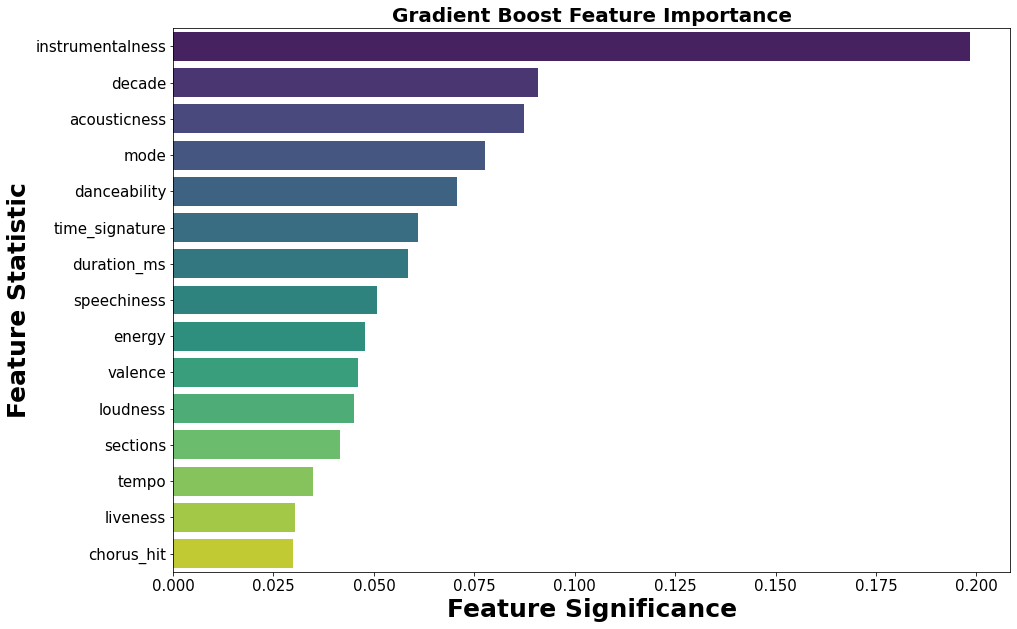

In [38]:
sigfeatures = list(zip(X_train.columns,gbm.feature_importances_))
sigfeatures= sorted(sigfeatures, key = lambda x: x[1], reverse=False)
sigfeatures = pd.DataFrame(sigfeatures, columns=['Feature','Significance'])
sigfeatures_final =  sigfeatures.sort_values('Significance',ascending = False)
sigfeatures_final = sigfeatures_final.head(15)
sigfeatures_final.sort_values(by = 'Significance',inplace= True, ascending =False)


g=sns.barplot(x="Significance", y="Feature", data=sigfeatures_final,palette ="viridis")
g.set_xlabel('Feature Significance',fontsize=25, fontweight='bold')
g.set_ylabel('Feature Statistic',fontsize=25, fontweight='bold')
g.xaxis.set_tick_params(labelsize=15)
g.yaxis.set_tick_params(labelsize=15)
g.set_title('Gradient Boost Feature Importance',fontsize=20, fontweight='bold')
plt.gcf().set_size_inches(15, 10)

Default threshold:
Precision: 0.7755,   Recall: 0.8542
ROC AUC score =  0.8837546748306762


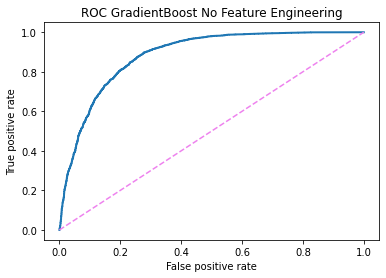

In [41]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, fit_model_n.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC GradientBoost No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, fit_model_n.predict_proba(X_val)[:,1]))

So XG Boost for the win so far performing slightly better than Random Forrest and still with the overpredicting hits.  Lets take a look at adding genre and previous hits to the model.

## Introduce Engineered Features

Now we will bring in our genre binary variables and our previous hits to see how they perform

In [42]:
#Create columns list to split with target, will look at genre dummy genre variables and previous hits after an initial run
x_feats = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'prev_hits', 'decade', 'hiphop', 'pop', 'rock',
       'techno', 'jazz', 'soul_blues']

In [43]:
tunez.columns

Index(['track', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'decade', 'prev_hits', 'hiphop', 'pop', 'rock',
       'techno', 'jazz', 'soul_blues', 'genre_class'],
      dtype='object')

In [44]:
# create X (features) and y (response)
X = tunez.loc[:,x_feats]
y = tunez['target']

In [45]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=2)

In [46]:
# print the shapes of the new X objects
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24663, 23)
(8221, 23)
(8222, 23)


In [47]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(24663,)
(8221,)
(8222,)


In [48]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
X_val_scaled = std.fit_transform(X_val)
X_test_scaled = std.fit_transform(X_test)
X_scaled = std.fit_transform(X_tr)

## KNN with Feature Engineering

In [49]:
k_range = list(range(1, 41))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y_tr, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.8134658938332375, 0.8133135852828014, 0.8293090531070536, 0.8346003581206691, 0.8350562850880211, 0.8398307434129395, 0.8381886295762844, 0.8416249068819681, 0.8403173429236583, 0.8426588684244983, 0.8409254582294887, 0.8432974805792959, 0.8404995657574205, 0.8422937477205965, 0.8406516338839409, 0.8433581228884307, 0.8395873974222117, 0.8426892820498025, 0.8389488037615616, 0.8405301458300505, 0.8387965969289359, 0.840773417844189, 0.8379756787167132, 0.8394353662839856, 0.8382188212718203, 0.8387359268785801, 0.836485512794621, 0.8387054855120548, 0.8374890607118471, 0.8385230407485247, 0.8372458164389297, 0.838431725896023, 0.8367590967162533, 0.8384621025330323, 0.8364246670498654, 0.8380363025317008, 0.8364245930732761, 0.8379146942658526, 0.8357555672931744, 0.8376714777341562]


Text(0, 0.5, 'Cross-Validated Accuracy')

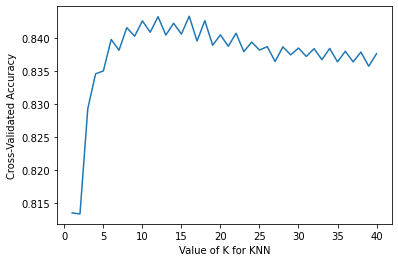

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Similar 10-15 for optimal K Nearest Neighbor

In [51]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X_scaled, y_tr, cv=10, scoring='accuracy')
print(scores)

[0.83764062 0.84645789 0.84645789 0.8458498  0.84580292 0.83667883
 0.84549878 0.8506691  0.8330292  0.83850365]


In [52]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.8426588684244983


Accuracy up .04 from previous set for KNN 

In [53]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_val_scaled)
print("Training set: ", knn.score(X_train_scaled, y_train))
print("Validation set: ", knn.score(X_val_scaled, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.8689129465190771
Validation set:  0.8429631431699307
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      4161
           1       0.83      0.86      0.84      4060

    accuracy                           0.84      8221
   macro avg       0.84      0.84      0.84      8221
weighted avg       0.84      0.84      0.84      8221



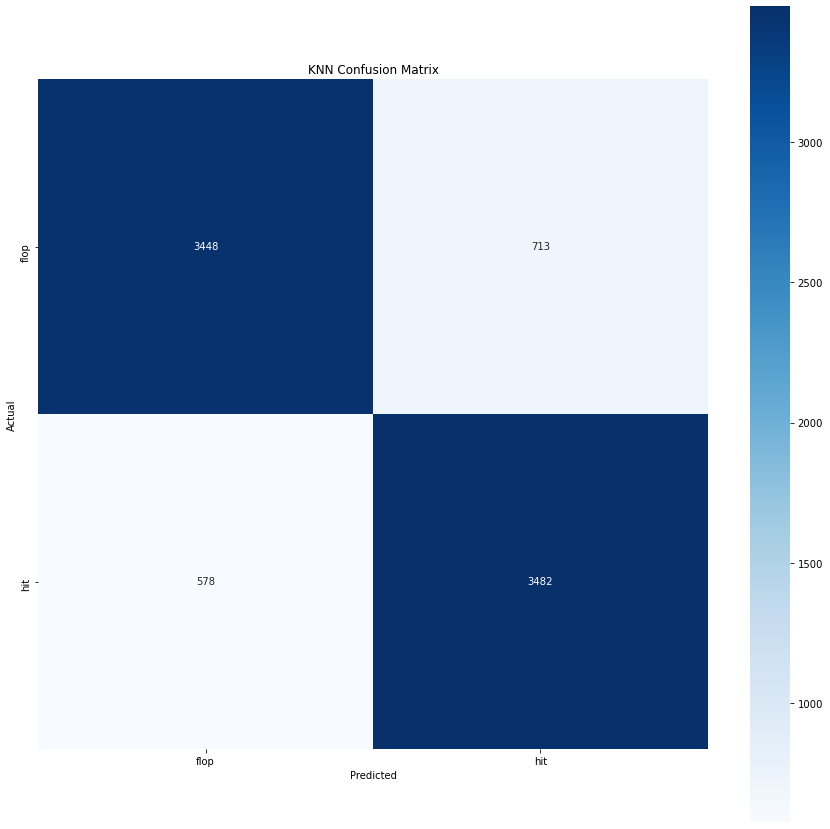

In [54]:
confusion(y_val, y_pred, "KNN")

Default threshold:
Precision: 0.8300,   Recall: 0.8576
ROC AUC score =  0.9213880532696882


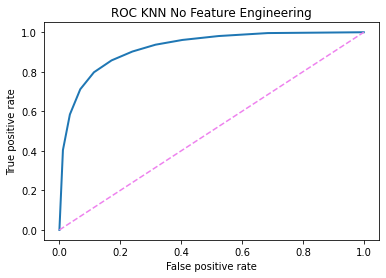

In [55]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC KNN No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))

So we are much better balanced on mistakes now (False Positive/negatives) and our ROC AUC for KNN has jumped nealry .10 from the previous looks and is better than the best of our prior models.  Let's continue to see how the other models perform. 

### Logistic Regression with Featuring engineering

In [56]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_val_scaled)
print("Training set: ", log_reg.score(X_train_scaled, y_train))
print("Validation set: ", log_reg.score(X_val_scaled, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.8927948749138386
Validation set:  0.8929570611847707
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4161
           1       0.92      0.86      0.89      4060

    accuracy                           0.89      8221
   macro avg       0.89      0.89      0.89      8221
weighted avg       0.89      0.89      0.89      8221



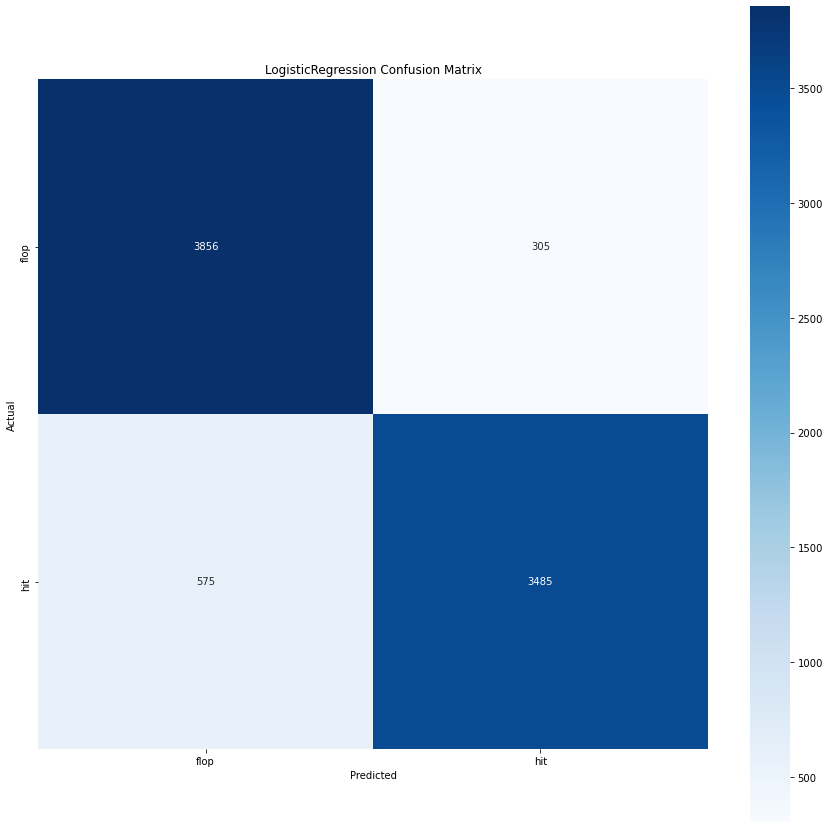

In [57]:
confusion(y_val, y_pred, "LogisticRegression")

Default threshold:
Precision: 0.9195,   Recall: 0.8584
ROC AUC score =  0.9629156736906035


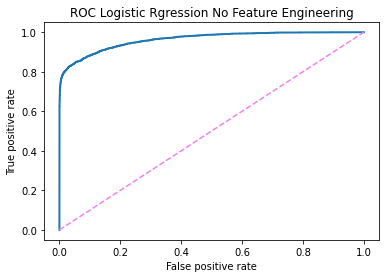

In [58]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, log_reg.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Logistic Rgression No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1]))

Considered changing threshold here but remembered it shouldn't impact ROC/AOC, we see a similar and even more impressive bump in logistic regression for ROC AUC and accuracy that we saw for KNN but it now outperforming KNN with the updated features.

With this model now we are actually over predictng flops relative to hits vs prior we had the opposite.

## RandomForrest with Featuring Engineering

In [60]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=300, max_depth=50) 
rf_model = rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)

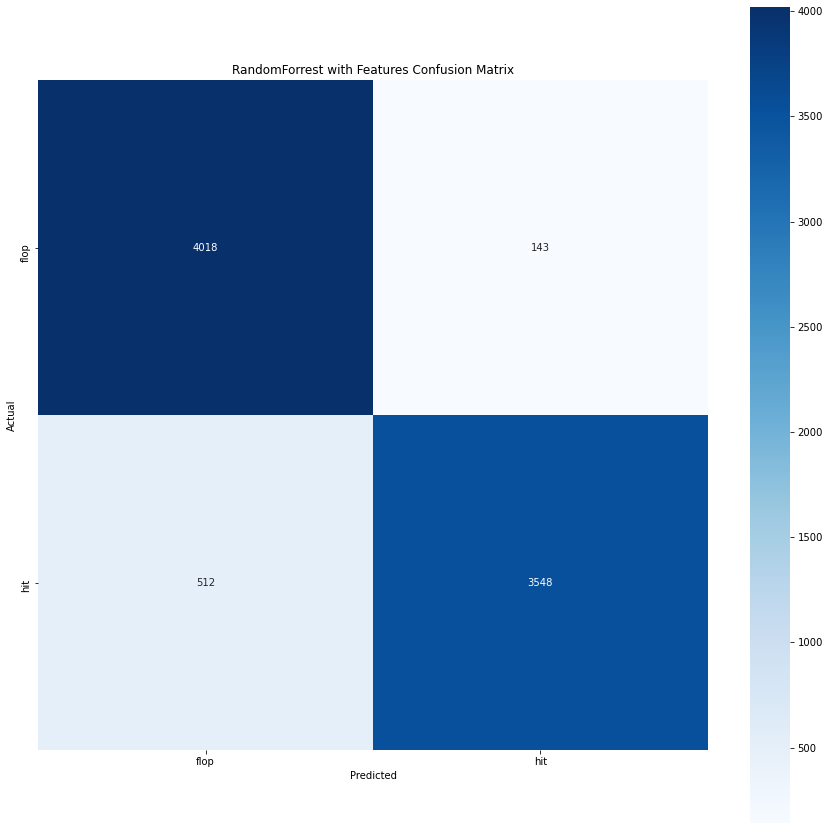

In [63]:
confusion(y_val, y_pred, "RandomForrest with Features")

In [61]:
print("Training set: ", rf_model.score(X_train, y_train))
print("Validation set: ", rf_model.score(X_val, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.9998378137290679
Validation set:  0.9203259944045736
              precision    recall  f1-score   support

           0       0.89      0.97      0.92      4161
           1       0.96      0.87      0.92      4060

    accuracy                           0.92      8221
   macro avg       0.92      0.92      0.92      8221
weighted avg       0.92      0.92      0.92      8221



Default threshold:
Precision: 0.9613,   Recall: 0.8739
ROC AUC score =  0.9753731873377348


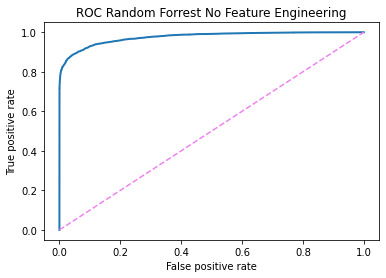

In [62]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Random Forrest No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, rf_model.predict_proba(X_val)[:,1]))

Best score yet for ROC AUC is for random forrest.  Let's try one more time with XG Boost.

## XG Boost with Feature Engineering

In [64]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=10,
                        objective='binary:logistic', #new objective
                        learning_rate=.2, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )
y_pred = fit_model.predict(X_val)
accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)) 


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9211774723269676

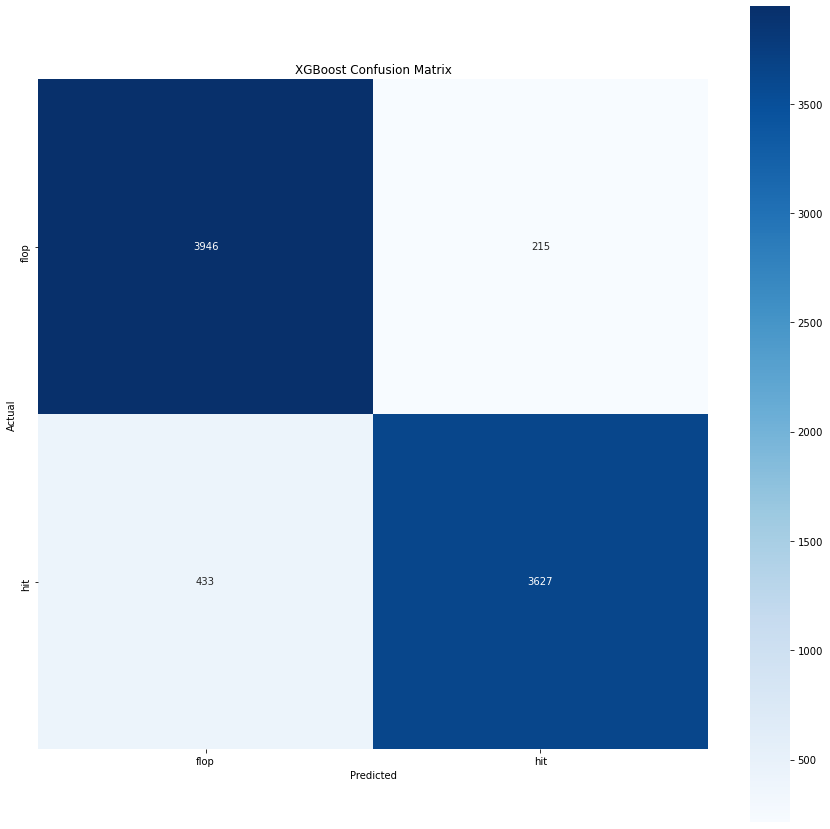

In [65]:
confusion(y_val, y_pred, "XGBoost")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

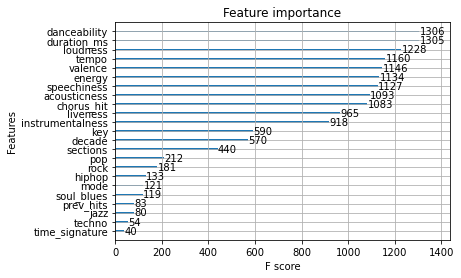

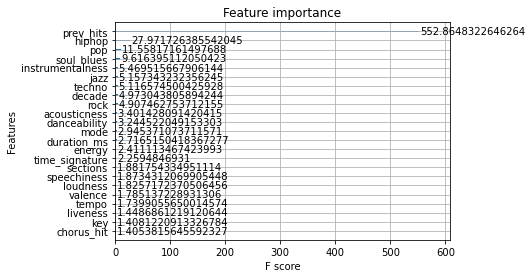

In [66]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

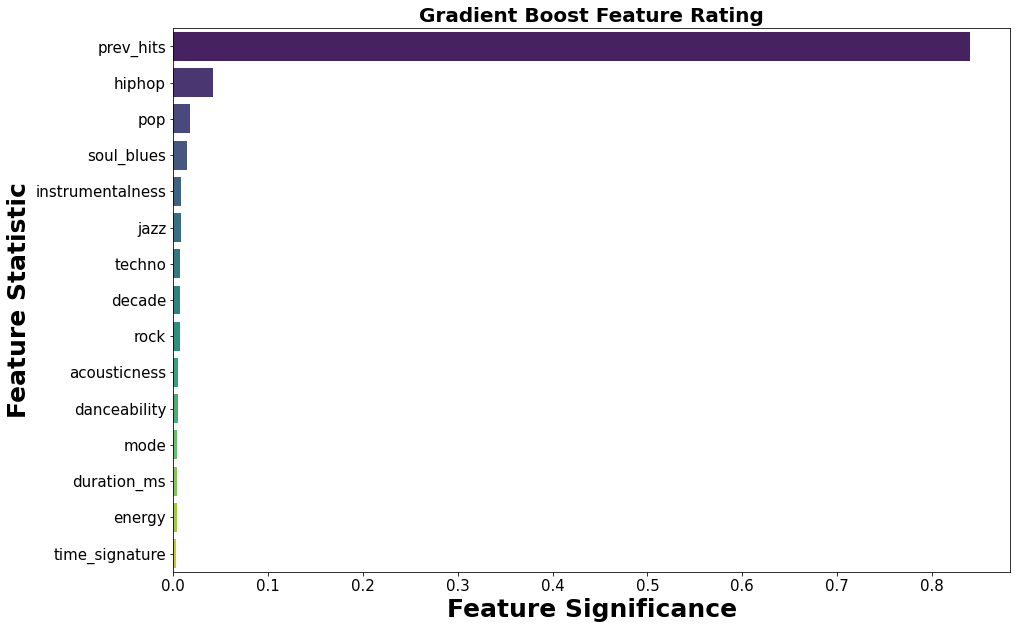

In [67]:
sigfeatures = list(zip(X_train.columns,gbm.feature_importances_))
sigfeatures= sorted(sigfeatures, key = lambda x: x[1], reverse=False)
sigfeatures = pd.DataFrame(sigfeatures, columns=['Feature','Significance'])
sigfeatures_final =  sigfeatures.sort_values('Significance',ascending = False)
sigfeatures_final = sigfeatures_final.head(15)
sigfeatures_final.sort_values(by = 'Significance',inplace= True, ascending =False)


g=sns.barplot(x="Significance", y="Feature", data=sigfeatures_final,palette ="viridis")
g.set_xlabel('Feature Significance',fontsize=25, fontweight='bold')
g.set_ylabel('Feature Statistic',fontsize=25, fontweight='bold')
g.xaxis.set_tick_params(labelsize=15)
g.yaxis.set_tick_params(labelsize=15)
g.set_title('Gradient Boost Feature Rating',fontsize=20, fontweight='bold')
plt.gcf().set_size_inches(15, 10)

Default threshold:
Precision: 0.9440,   Recall: 0.8933
ROC AUC score =  0.9772664419669863


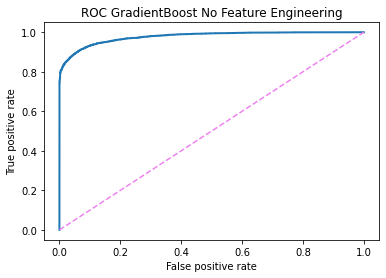

In [68]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, fit_model.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC GradientBoost No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, fit_model.predict_proba(X_val)[:,1]))

We have a winner from an ROC AUC perspective.  Looking at the feature importance for XGBoost we can see just how important a previous hit was in this dataset. The genres also appeared to be used quite a bit in terms of decision making. 

Before we just give XGBoost its prize let's take a look at one or two more options.

## Gaussian Naive Bayes 

In [69]:
#prepare cross vall template use cross fold for various models
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
gnb = GaussianNB()
scores = cross_val_score(gnb, X_train_scaled, y_train, scoring='roc_auc', cv=cv)
score = np.mean(scores)

y_pred = gnb.fit(X_train_scaled, y_train).predict(X_val_scaled)

In [70]:
print("Training set: ", gnb.score(X_train_scaled, y_train))
print("Validation set: ", gnb.score(X_val_scaled, y_val))
print(classification_report(y_val, y_pred))

Training set:  0.8869967157280136
Validation set:  0.8897944289015934
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4161
           1       0.90      0.87      0.89      4060

    accuracy                           0.89      8221
   macro avg       0.89      0.89      0.89      8221
weighted avg       0.89      0.89      0.89      8221



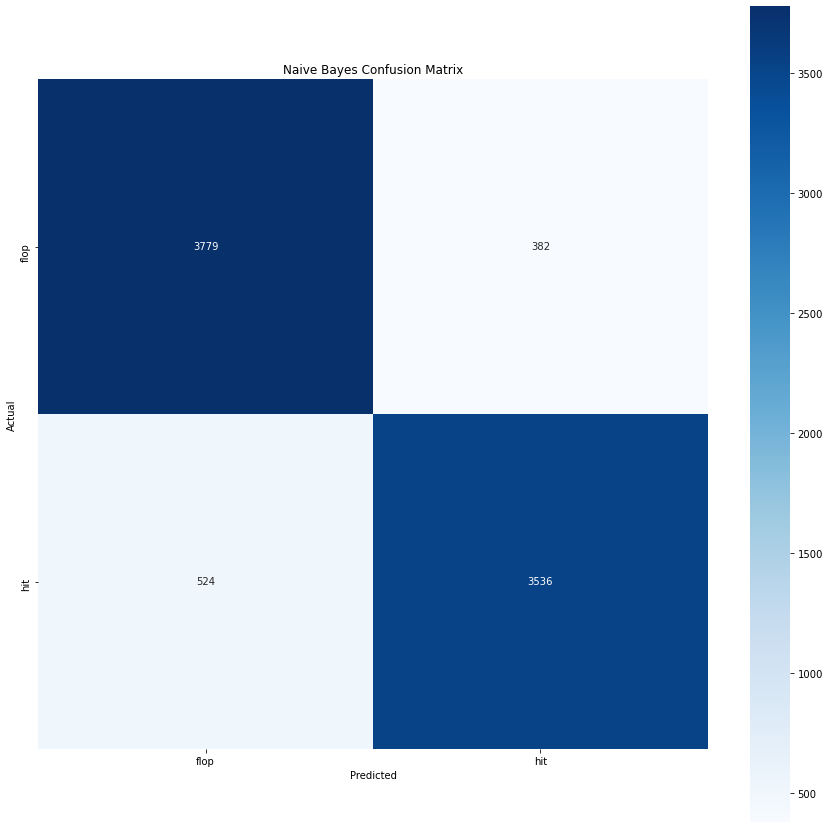

In [72]:
confusion(y_val, y_pred, "Naive Bayes")

Default threshold:
Precision: 0.9025,   Recall: 0.8709
ROC AUC score =  0.9576944546060475


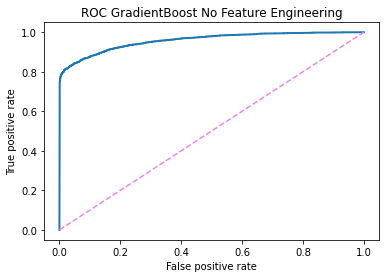

In [71]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_val, y_pred), 
                                                     recall_score(y_val, y_pred)))
fpr, tpr, thresholds = roc_curve(y_val, gnb.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC GradientBoost No Feature Engineering');
print("ROC AUC score = ", roc_auc_score(y_val, gnb.predict_proba(X_val_scaled)[:,1]))

Wow so clearly the fact the many artists that have hits don't have flops in the data set is impactign things as previous hits is clealry dominating.  Our genre categories appear to be helping too as they are up there with instrumentalness in terms of feature importance.  Thus far we've generally been looking at accuracy and ROC AUC to see if the feature engineering helped and up till now it has.  

It appears Trees and Boost are the winners followed by Logistic Regression, Naive Bayes and then KNN. 

Text(0, 0.5, 'True positive rate (Sensitivity)')

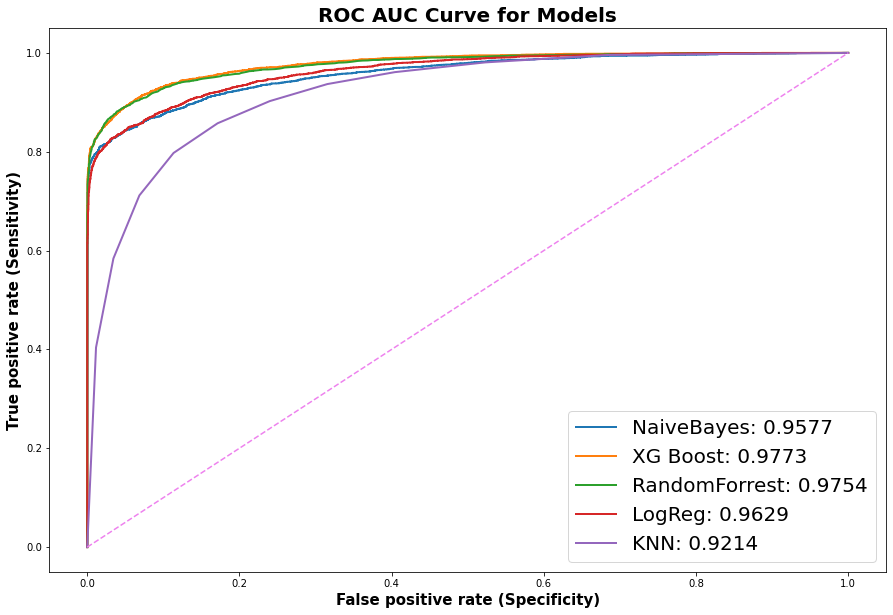

In [73]:
rcParams['figure.figsize'] = 15,10
nb_auc = roc_auc_score(y_val, gnb.predict_proba(X_val_scaled)[:,1])
XG_auc = roc_auc_score(y_val, fit_model.predict_proba(X_val)[:,1])
RF_auc = roc_auc_score(y_val, rf_model.predict_proba(X_val)[:,1])
Log_auc = roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])
knn_auc = roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1])

fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, gnb.predict_proba(X_val_scaled)[:,1])
fpr_XGB, tpr_XGB, thresholds_XBG = roc_curve(y_val, fit_model.predict_proba(X_val)[:,1])
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_val, rf_model.predict_proba(X_val)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, log_reg.predict_proba(X_val_scaled)[:,1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])

plt.plot(fpr_nb, tpr_nb,lw=2,label = "NaiveBayes: {:.4f}".format(nb_auc))
plt.plot(fpr_XGB, tpr_XGB,lw=2, label = "XG Boost: {:.4f}".format(XG_auc))
plt.plot(fpr_RF,tpr_RF,lw=2,label = "RandomForrest: {:.4f}".format(RF_auc))
plt.plot(fpr_log,tpr_log,lw=2,label = "LogReg: {:.4f}".format(Log_auc))
plt.plot(fpr_knn,tpr_knn,lw=2,label = "KNN: {:.4f}".format(knn_auc))

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.title('ROC AUC Curve for Models',fontsize = 20, fontweight='bold')
plt.legend(loc="lower right",prop={'size': 20})
plt.xlabel('False positive rate (Specificity)', fontsize = 15, fontweight='bold')
plt.ylabel('True positive rate (Sensitivity)',fontsize = 15, fontweight='bold')

### Voting Classfier

Let's take a look at our top 3 models outside of XG Boost to see how they perform as a group and see if they can do better than XG Boost, 

In [76]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

voting = VotingClassifier(
            estimators=[('rf', rf_model), ('LogReg',log_reg),('NBayes',gnb)],
            voting='soft',
            n_jobs=-1)
vote = voting.fit(X_train_scaled, y_train)

In [77]:
print("ROC AUC score = ", roc_auc_score(y_val, vote.predict_proba(X_val_scaled)[:,1]))

ROC AUC score =  0.9681616061883571


Trying to do a voting classifier of our next three top models to see if it outperforms XG Boost and it does not. Initially attemped to include XG Boost but the run times started exceeding hours to run, so decided to let it stay as is. 

## Final Model Selection - XG Boost

XG Boost has perfomed the best so far, so Let's run with it for our final model.  First we will refit on all the train and validation set for testing the test set.

In [78]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=10,
                        objective='binary:logistic', #new objective
                        learning_rate=.2, 
                        subsample=1,
                        min_child_weight=1,
                        colsample_bytree=.8
                       )

eval_set=[(X_tr,y_tr),(X_test,y_test)]

fit_model = gbm.fit( 
                    X_tr, y_tr, 
                    eval_set=eval_set,
                    eval_metric='auc', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )
y_pred = fit_model.predict(X_test)
accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.9172950620287035

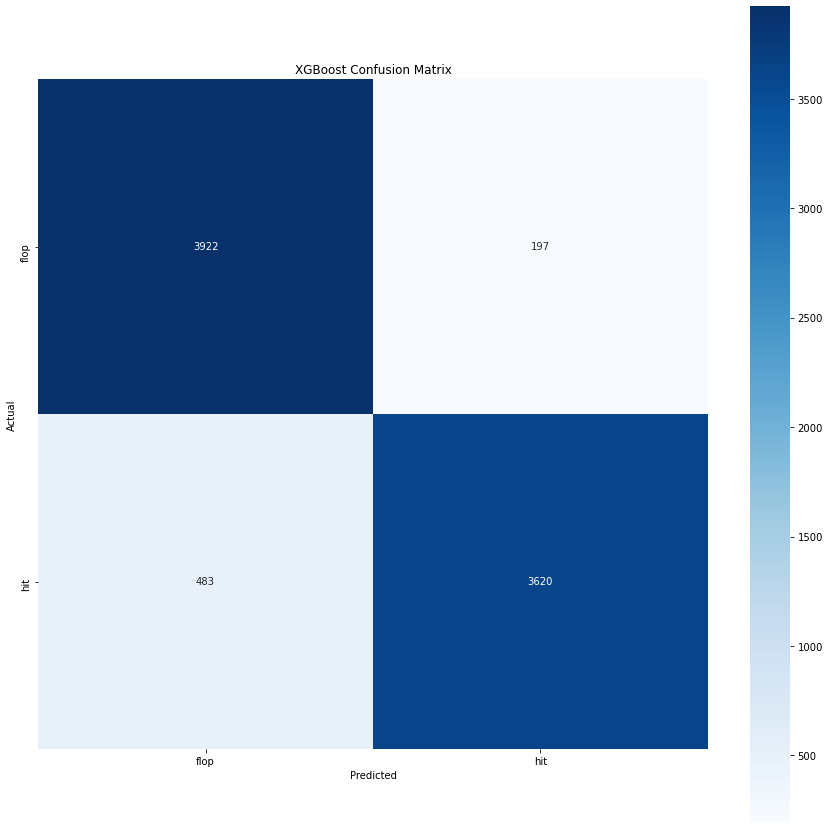

In [79]:
confusion(y_test, y_pred, "XGBoost")

Looks like we are still missing more hits then we are missing hits that are flops

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

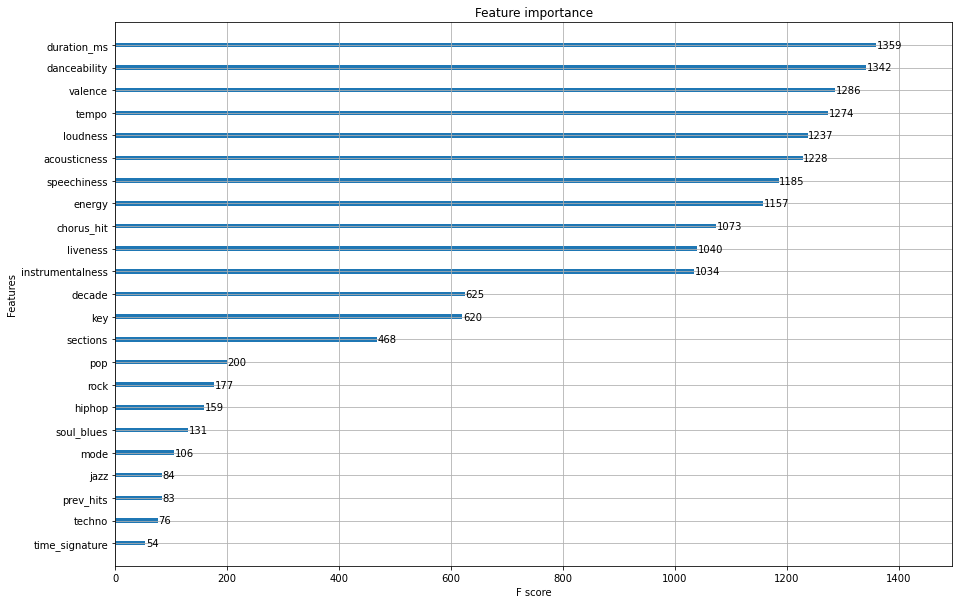

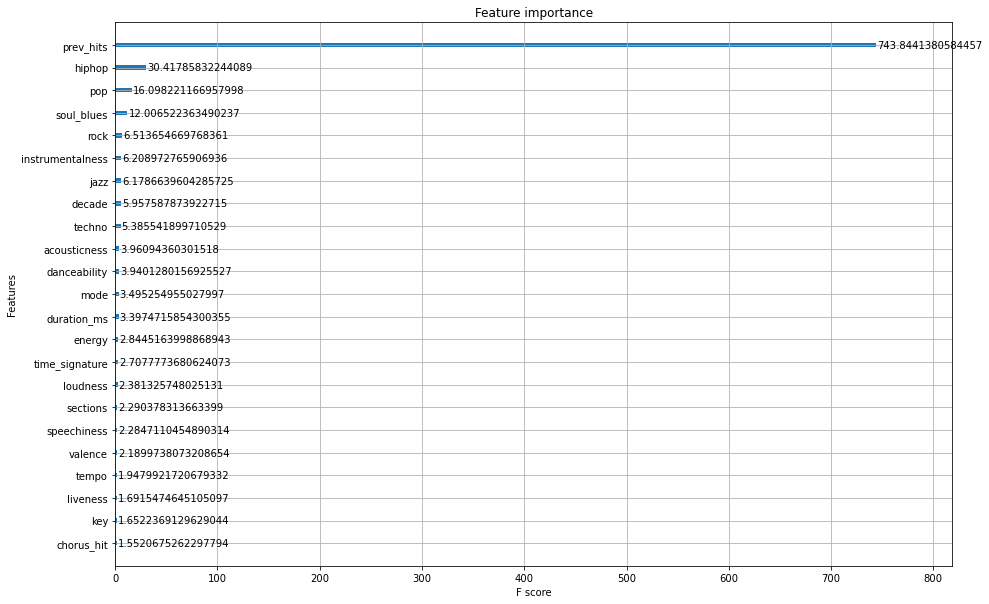

In [80]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

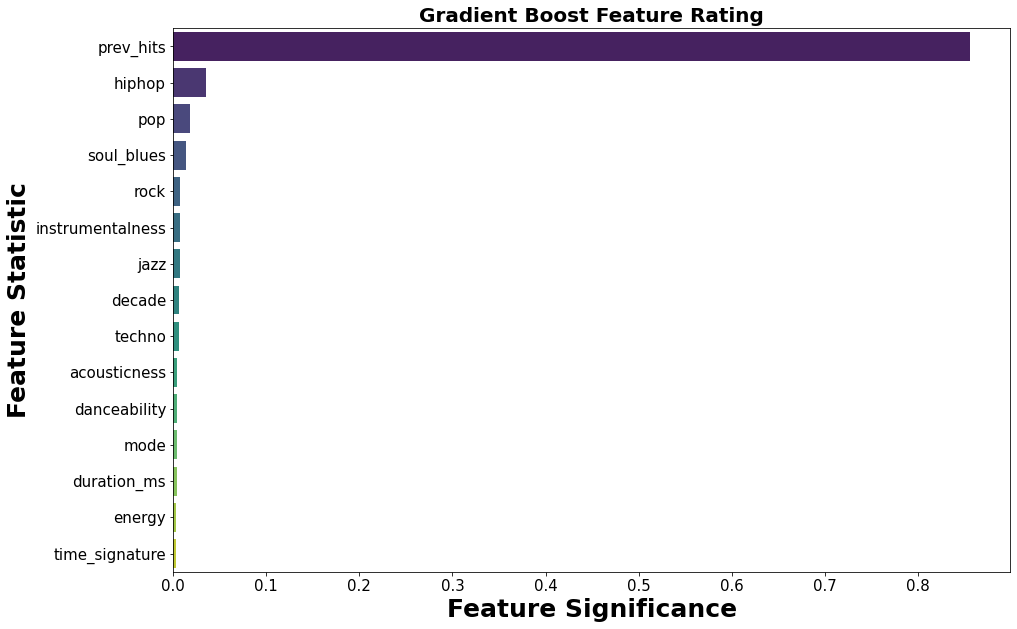

In [81]:
sigfeatures = list(zip(X_train.columns,gbm.feature_importances_))
sigfeatures= sorted(sigfeatures, key = lambda x: x[1], reverse=False)
sigfeatures = pd.DataFrame(sigfeatures, columns=['Feature','Significance'])
sigfeatures_final =  sigfeatures.sort_values('Significance',ascending = False)
sigfeatures_final = sigfeatures_final.head(15)
sigfeatures_final.sort_values(by = 'Significance',inplace= True, ascending =False)


g=sns.barplot(x="Significance", y="Feature", data=sigfeatures_final,palette ="viridis")
g.set_xlabel('Feature Significance',fontsize=25, fontweight='bold')
g.set_ylabel('Feature Statistic',fontsize=25, fontweight='bold')
g.xaxis.set_tick_params(labelsize=15)
g.yaxis.set_tick_params(labelsize=15)
g.set_title('Gradient Boost Feature Rating',fontsize=20, fontweight='bold')
plt.gcf().set_size_inches(15, 10)

Default threshold:
Precision: 0.9484,   Recall: 0.8823
ROC AUC score =  0.9765781076583628


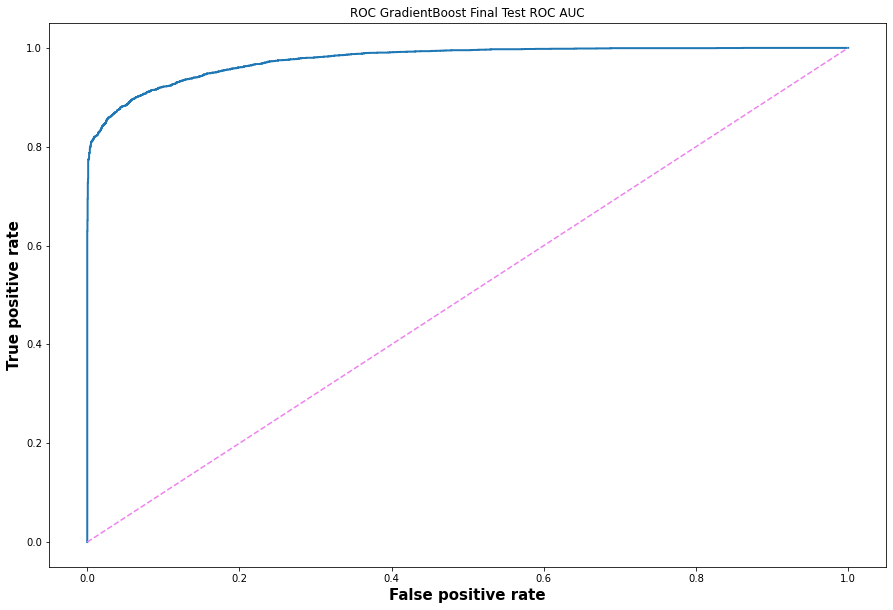

In [143]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_pred), 
                                                     recall_score(y_test, y_pred)))
fpr, tpr, thresholds = roc_curve(y_test, fit_model.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate',fontsize = 15,fontweight='bold')
plt.ylabel('True positive rate',fontsize = 15,fontweight='bold')
plt.title('ROC GradientBoost Final Test ROC AUC');
print("ROC AUC score = ", roc_auc_score(y_test, fit_model.predict_proba(X_test)[:,1]))

Not bad with our highest AUC/ROC score yet but again our model is under predicting hits with XG Boost.  Now we need to put this ranking system to the test.  We will take a data set derived from the Top 100 Billboard hits from this week using the Billboard API package and then the songs and their qualities pulled via the Spotify API (see Spotify python notebook)

### Billboard Top 100 - Predicting Hits and Rank Correlation - XGBoost with Feature Engineered

Let's see how our model does on predicting whether all the songs in the top 100 will be a hit and if we have similar rankings to the current billboard list

In [83]:
new100 = pd.read_pickle('new100.pickle')
new100

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,target,decade,prev_hits,hiphop,pop,rock,techno,jazz,soul_blues,genre_class
0,Save Your Tears (with Ariana Grande) (Remix),The Weeknd,0.650,0.825,0,-4.645,1,0.0325,0.02150,0.000024,...,1,2020,32,1,1,0,0,0,0,Pop_Hip_Hop
1,Leave The Door Open,Bruno Mars,0.586,0.616,5,-7.964,1,0.0324,0.18200,0.000000,...,1,2020,13,0,1,0,0,0,0,Pop
2,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,0.677,0.696,0,-6.181,1,0.1190,0.32100,0.000000,...,1,2020,30,0,1,0,0,0,0,Pop
3,Levitating (feat. DaBaby),Dua Lipa,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.000000,...,1,2020,3,0,1,0,0,0,0,Pop
4,Kiss Me More (feat. SZA),Doja Cat,0.762,0.701,8,-3.541,1,0.0286,0.23500,0.000158,...,1,2020,1,1,1,0,0,0,0,Pop_Hip_Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,If Pain Was A Person,Moneybagg Yo,0.584,0.611,0,-8.692,1,0.5200,0.06940,0.000000,...,1,2020,5,1,0,0,0,0,0,Hip_Hop_RB
96,Tampa,Cico P,0.888,0.408,8,-10.162,0,0.4870,0.16400,0.000000,...,1,2020,0,0,0,0,0,0,0,Other
97,Hello (feat. A Boogie Wit da Hoodie),Pop Smoke,0.905,0.647,10,-5.065,0,0.1070,0.01870,0.000000,...,1,2020,1,0,0,0,0,0,0,Other
98,Way Less Sad,AJR,0.701,0.547,2,-8.238,1,0.0483,0.00843,0.000000,...,1,2020,2,0,0,1,0,0,0,Rock


In [84]:
#Create columns list to split with target, will look at genre dummy genre variables and previous hits after an initial run
x_feats = ['danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'prev_hits', 'decade', 'hiphop', 'pop', 'rock',
       'techno', 'jazz', 'soul_blues']

In [85]:
# create X (features) and y (response)
X100 = new100.loc[:,x_feats]
y100 = new100['target']

In [86]:
j = fit_model.predict_proba(X100)

In [87]:
j =pd.DataFrame(j)

In [88]:
result = pd.concat([new100, j], axis=1)

In [89]:
result = result.rename(columns={0:"Flop",1:"Hit"})

In [90]:
result.sort_values(by="Hit",ascending = False)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,prev_hits,hiphop,pop,rock,techno,jazz,soul_blues,genre_class,Flop,Hit
22,Forever After All,Luke Combs,0.487,0.650,0,-5.195,1,0.0253,0.191000,0.000000,...,8,0,0,1,0,0,0,Rock,0.000099,0.999901
31,Made For You,Jake Owen,0.581,0.441,1,-6.829,1,0.0268,0.770000,0.000028,...,16,0,0,1,0,0,0,Rock,0.000104,0.999896
62,Gone,Dierks Bentley,0.521,0.746,6,-6.173,1,0.0351,0.009850,0.000000,...,26,0,0,1,0,0,0,Rock,0.000106,0.999894
19,EVERY CHANCE I GET (feat. Lil Baby & Lil Durk),DJ Khaled,0.477,0.727,2,-4.053,1,0.2860,0.000866,0.000000,...,26,1,1,0,0,0,0,Hip_Hop_RB,0.000112,0.999888
39,Breaking Up Was Easy In The 90's,Sam Hunt,0.562,0.649,9,-5.400,1,0.0494,0.231000,0.000000,...,7,1,1,1,1,1,1,Other,0.000113,0.999887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,telepatía,Kali Uchis,0.653,0.524,11,-9.016,0,0.0502,0.112000,0.000000,...,0,0,1,0,0,0,0,Pop,0.852127,0.147873
82,4 Da Gang (with Roddy Ricch),42 Dugg,0.871,0.545,7,-10.489,1,0.1890,0.014300,0.000000,...,0,1,0,0,0,0,0,Hip_Hop_RB,0.858014,0.141986
88,Arcade,Duncan Laurence,0.450,0.329,9,-12.603,0,0.0441,0.818000,0.001090,...,0,0,1,0,0,0,0,Pop,0.891548,0.108452
96,Tampa,Cico P,0.888,0.408,8,-10.162,0,0.4870,0.164000,0.000000,...,0,0,0,0,0,0,0,Other,0.900840,0.099160


Looks like we did not nail the tops or bottoms very well. Our model seems to like country artist with 4 of the top 5 from that subcategory of the Rock category.

Let's take a look if we predicted hit or flops for songs

In [91]:
result[result['Flop']>.5]

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,prev_hits,hiphop,pop,rock,techno,jazz,soul_blues,genre_class,Flop,Hit
6,Astronaut In The Ocean,Masked Wolf,0.778,0.695,4,-6.865,0,0.0913,0.17500,0.000000,...,0,1,0,0,0,0,0,Hip_Hop_RB,0.746073,0.253927
7,WITHOUT YOU,The Kid LAROI,0.662,0.413,0,-7.357,1,0.0299,0.21300,0.000000,...,0,1,0,0,0,0,0,Hip_Hop_RB,0.571899,0.428101
13,drivers license,Olivia Rodrigo,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,...,0,0,1,0,0,0,0,Pop,0.698594,0.301406
25,What You Know Bout Love,Pop Smoke,0.709,0.548,10,-8.493,1,0.3530,0.65000,0.000002,...,0,0,0,0,0,0,0,Other,0.911328,0.088672
30,Track Star,Mooski,0.641,0.598,7,-5.700,0,0.3240,0.38100,0.000000,...,0,0,0,0,0,0,0,Other,0.694233,0.305767
33,Heat Waves,Glass Animals,0.761,0.525,11,-6.900,1,0.0944,0.44000,0.000007,...,0,0,1,0,0,0,0,Pop,0.558834,0.441166
34,you broke me first,Tate McRae,0.667,0.373,4,-9.389,1,0.0500,0.78500,0.000000,...,0,0,1,0,1,0,0,Pop_Techno,0.523707,0.476293
45,telepatía,Kali Uchis,0.653,0.524,11,-9.016,0,0.0502,0.11200,0.000000,...,0,0,1,0,0,0,0,Pop,0.852127,0.147873
47,Ski,Young Stoner Life,0.953,0.621,8,-7.638,0,0.2210,0.01700,0.000000,...,0,0,0,0,0,0,0,Other,0.649817,0.350183
64,Quicksand,Morray,0.901,0.673,4,-6.545,0,0.3140,0.07610,0.000000,...,0,0,0,0,0,0,0,Other,0.510578,0.489422


We are predicting 15 Flops in the top 100 songs based on a .50 threshold. So we guessed 85% hits. This is slightly below our accuracy from priod models in the high 80s/low 90s.

They all have a commom theme too, they don't have prior hits... BUT we have 25 songs in the top 100 with 0 prev_hits, so doesn't appear to impact all of the 0 previous hit category

Let's take a look at the probabilities and see the distribution of our predictions

Text(0.5, 1.0, 'Probability of Hit Songs in Billboard Top 100')

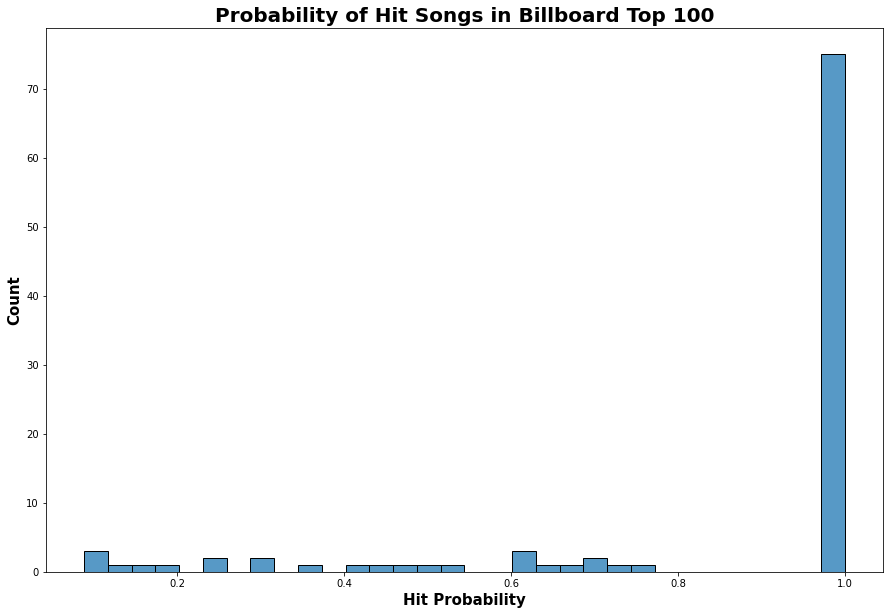

In [92]:
plt.figure(figsize=(15,10))

sns.histplot(data=result, x="Hit")
plt.xlabel('Hit Probability', fontsize = 15, fontweight ='bold')
plt.ylabel('Count',fontsize = 15, fontweight ='bold')
plt.title("Probability of Hit Songs in Billboard Top 100",fontsize = 20, fontweight='bold')

Lot of high percentage hit calcs with a mixing across the board at lower probabilities. Let's take a look at how our ranking compares vs whats in the top 100 right now.  The higher the hit probability should correlate with the top song.  In this case we will be reversing the order (i.e. Top song is ranked 100 to and last song is ranked 1) to get the directionality sync'ed up for the correlation calculation

In [95]:
result['rank'] = result.index
result['rank'] = result['rank'] + 1
result['rank'] = result['rank'].rank(ascending=False)

In [96]:
result

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,hiphop,pop,rock,techno,jazz,soul_blues,genre_class,Flop,Hit,rank
0,Save Your Tears (with Ariana Grande) (Remix),The Weeknd,0.650,0.825,0,-4.645,1,0.0325,0.02150,0.000024,...,1,1,0,0,0,0,Pop_Hip_Hop,0.000249,0.999751,100.0
1,Leave The Door Open,Bruno Mars,0.586,0.616,5,-7.964,1,0.0324,0.18200,0.000000,...,0,1,0,0,0,0,Pop,0.000165,0.999835,99.0
2,Peaches (feat. Daniel Caesar & Giveon),Justin Bieber,0.677,0.696,0,-6.181,1,0.1190,0.32100,0.000000,...,0,1,0,0,0,0,Pop,0.000273,0.999727,98.0
3,Levitating (feat. DaBaby),Dua Lipa,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.000000,...,0,1,0,0,0,0,Pop,0.001113,0.998887,97.0
4,Kiss Me More (feat. SZA),Doja Cat,0.762,0.701,8,-3.541,1,0.0286,0.23500,0.000158,...,1,1,0,0,0,0,Pop_Hip_Hop,0.003104,0.996896,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,If Pain Was A Person,Moneybagg Yo,0.584,0.611,0,-8.692,1,0.5200,0.06940,0.000000,...,1,0,0,0,0,0,Hip_Hop_RB,0.000217,0.999783,5.0
96,Tampa,Cico P,0.888,0.408,8,-10.162,0,0.4870,0.16400,0.000000,...,0,0,0,0,0,0,Other,0.900840,0.099160,4.0
97,Hello (feat. A Boogie Wit da Hoodie),Pop Smoke,0.905,0.647,10,-5.065,0,0.1070,0.01870,0.000000,...,0,0,0,0,0,0,Other,0.001878,0.998122,3.0
98,Way Less Sad,AJR,0.701,0.547,2,-8.238,1,0.0483,0.00843,0.000000,...,0,0,1,0,0,0,Rock,0.001316,0.998684,2.0


In [97]:
result['rank'].corr(result['Hit'], method='spearman')

-0.030051005100510043

In [98]:
result.sort_values(by='Hit',ascending=False)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,hiphop,pop,rock,techno,jazz,soul_blues,genre_class,Flop,Hit,rank
23,Forever After All,Luke Combs,0.487,0.650,0,-5.195,1,0.0253,0.191000,0.000000,...,0,0,1,0,0,0,Rock,0.000099,0.999901,78.0
32,Made For You,Jake Owen,0.581,0.441,1,-6.829,1,0.0268,0.770000,0.000028,...,0,0,1,0,0,0,Rock,0.000104,0.999896,69.0
63,Gone,Dierks Bentley,0.521,0.746,6,-6.173,1,0.0351,0.009850,0.000000,...,0,0,1,0,0,0,Rock,0.000106,0.999894,38.0
20,EVERY CHANCE I GET (feat. Lil Baby & Lil Durk),DJ Khaled,0.477,0.727,2,-4.053,1,0.2860,0.000866,0.000000,...,1,1,0,0,0,0,Hip_Hop_RB,0.000112,0.999888,81.0
40,Breaking Up Was Easy In The 90's,Sam Hunt,0.562,0.649,9,-5.400,1,0.0494,0.231000,0.000000,...,1,1,1,1,1,1,Other,0.000113,0.999887,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,telepatía,Kali Uchis,0.653,0.524,11,-9.016,0,0.0502,0.112000,0.000000,...,0,1,0,0,0,0,Pop,0.852127,0.147873,55.0
83,4 Da Gang (with Roddy Ricch),42 Dugg,0.871,0.545,7,-10.489,1,0.1890,0.014300,0.000000,...,1,0,0,0,0,0,Hip_Hop_RB,0.858014,0.141986,18.0
89,Arcade,Duncan Laurence,0.450,0.329,9,-12.603,0,0.0441,0.818000,0.001090,...,0,1,0,0,0,0,Pop,0.891548,0.108452,12.0
97,Tampa,Cico P,0.888,0.408,8,-10.162,0,0.4870,0.164000,0.000000,...,0,0,0,0,0,0,Other,0.900840,0.099160,4.0


Text(0.5, 1.0, 'Distribution of Previous Hits for Artists in Top 100')

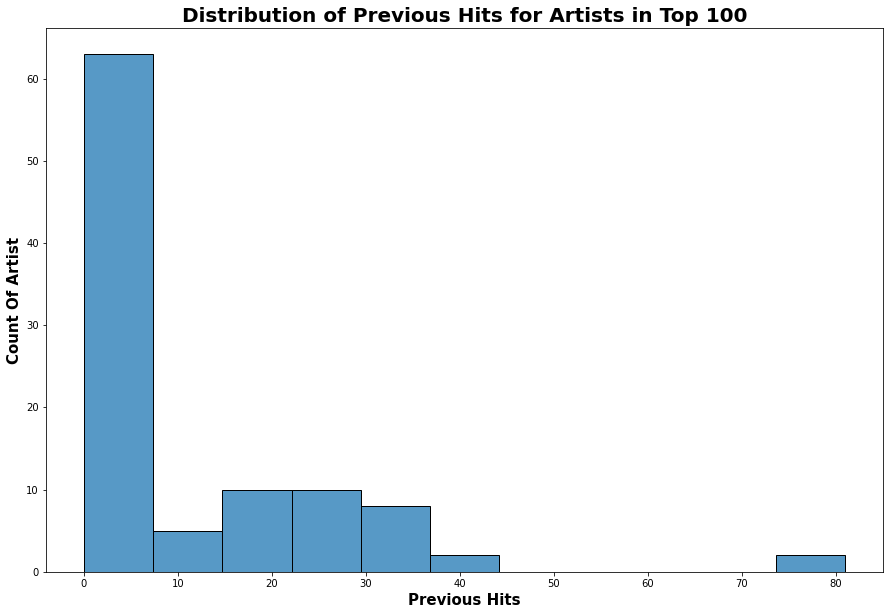

In [141]:
plt.figure(figsize=(15,10))

sns.histplot(data=result, x="prev_hits")
plt.xlabel('Previous Hits', fontsize = 15, fontweight ='bold')
plt.ylabel('Count Of Artist',fontsize = 15, fontweight ='bold')
plt.title("Distribution of Previous Hits for Artists in Top 100",fontsize = 20, fontweight='bold')

Hi Drake (looks at 80 point)

In [100]:
test = result[result['prev_hits'] > 0]

Let's look at if we remove the 0 hits if our correlation performs any differently.  

In [101]:
test['rank'].corr(test['Hit'], method='spearman')

-0.013655761024182077

Not really any change.  Let's take a look at this process WITHOUT the feature engineered aspects and see if the model performs any better.

In [103]:
# create X (features) and y (response)
X100 = new100.loc[:,xs]
y100 = new100['target']

In [104]:
j = fit_model_n.predict_proba(X100) #updated to the prior modeling in XGBoost without features

In [105]:
j =pd.DataFrame(j)

In [106]:
result = pd.concat([new100, j], axis=1)

In [107]:
result = result.rename(columns={0:"Flop",1:"Hit"})

In [108]:
result.sort_values(by="Hit",ascending = False)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,prev_hits,hiphop,pop,rock,techno,jazz,soul_blues,genre_class,Flop,Hit
52,Solid (feat. Drake),Young Stoner Life,0.887,0.485,11,-9.358,0,0.2000,0.0392,0.000000,...,1,0,0,0,0,0,0,Other,0.014602,0.985398
93,Drankin N Smokin,Future,0.752,0.658,0,-6.297,1,0.3420,0.0421,0.000000,...,19,1,1,0,0,0,0,Hip_Hop_RB,0.016655,0.983345
86,LA NOCHE DE ANOCHE,Bad Bunny,0.856,0.618,7,-4.892,1,0.2860,0.0303,0.000000,...,3,1,0,0,0,0,0,Hip_Hop_RB,0.018980,0.981020
65,Quicksand,Morray,0.901,0.673,4,-6.545,0,0.3140,0.0761,0.000000,...,0,0,0,0,0,0,0,Other,0.022166,0.977834
19,Beautiful Mistakes (feat. Megan Thee Stallion),Maroon 5,0.713,0.676,10,-5.483,1,0.0270,0.0377,0.000000,...,26,0,1,1,0,0,0,Rock_Pop,0.027237,0.972763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,Hell Of A View,Eric Church,0.689,0.582,5,-6.778,1,0.0236,0.1190,0.004640,...,20,0,0,1,0,0,0,Rock,0.691623,0.308377
49,Good Days,SZA,0.436,0.655,1,-8.370,0,0.0583,0.4990,0.000008,...,3,1,1,0,0,0,0,Hip_Hop_RB,0.696610,0.303390
33,Therefore I Am,Billie Eilish,0.889,0.340,11,-7.773,0,0.0697,0.2180,0.130000,...,16,0,1,0,1,0,0,Pop_Techno,0.721049,0.278951
10,Your Power,Billie Eilish,0.634,0.285,9,-14.007,0,0.0807,0.9370,0.000359,...,15,0,1,0,1,0,0,Pop_Techno,0.807389,0.192611


In [109]:
result[result['Flop']>.5]

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,prev_hits,hiphop,pop,rock,techno,jazz,soul_blues,genre_class,Flop,Hit
10,Your Power,Billie Eilish,0.634,0.285,9,-14.007,0,0.0807,0.9370,0.000359,...,15,0,1,0,1,0,0,Pop_Techno,0.807389,0.192611
22,Heartbreak Anniversary,Giveon,0.449,0.465,0,-8.964,1,0.0791,0.5240,0.000001,...,0,1,1,0,0,0,0,Pop_Hip_Hop,0.566334,0.433666
33,Therefore I Am,Billie Eilish,0.889,0.340,11,-7.773,0,0.0697,0.2180,0.130000,...,16,0,1,0,1,0,0,Pop_Techno,0.721049,0.278951
36,Hell Of A View,Eric Church,0.689,0.582,5,-6.778,1,0.0236,0.1190,0.004640,...,20,0,0,1,0,0,0,Rock,0.691623,0.308377
38,DÁKITI,Bad Bunny,0.731,0.573,4,-10.059,0,0.0544,0.4010,0.000052,...,2,1,0,0,0,0,0,Hip_Hop_RB,0.501280,0.498720
49,Good Days,SZA,0.436,0.655,1,-8.370,0,0.0583,0.4990,0.000008,...,3,1,1,0,0,0,0,Hip_Hop_RB,0.696610,0.303390
50,Goosebumps - Remix,Travis Scott,0.841,0.593,1,-7.846,1,0.0379,0.4180,0.000000,...,10,1,0,0,1,0,0,Techno_Hip_Hop,0.542845,0.457155
74,Glad You Exist,Dan + Shay,0.748,0.551,11,-6.120,1,0.0349,0.2350,0.000000,...,7,0,1,1,0,0,0,Rock_Pop,0.540234,0.459766
83,4 Da Gang (with Roddy Ricch),42 Dugg,0.871,0.545,7,-10.489,1,0.1890,0.0143,0.000000,...,0,1,0,0,0,0,0,Hip_Hop_RB,0.583923,0.416077
89,Arcade,Duncan Laurence,0.450,0.329,9,-12.603,0,0.0441,0.8180,0.001090,...,0,0,1,0,0,0,0,Pop,0.857173,0.142827


Without the genre and previous hits as part of our model we are actually predicting less flops and a heavier distribution of artists with prior success. We have a total of 88 hits which is slightly better accuracy than our previous run through with genre/previous success.

In [110]:
result['rank'] = result.index
result['rank'] = result['rank'] + 1
result['rank'] = result['rank'].rank(ascending=False)

In [111]:
result['rank'].corr(result['Hit'], method='spearman')

0.01374137413741374

Still a low correlation in terms of our ranking algorith vs current rankings.  Let's look at an album example and see how we do.

## To Pimp A Butterfly

Let's now look at Kendrick Lamar's album and see how our ranks compare with stream plays and secondarily in importance if we predicted a hit or not.

In [112]:
kendrick = pd.read_pickle('kendrick.pickle')
kendrick

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,decade,prev_hits,jazz,soul_blues,hiphop,pop,rock,techno,genre_class,streams
0,Wesley's Theory,Kendrick Lamar,0.509,0.787,7,-6.754,1,0.2650,0.35900,0.000028,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,7570411
1,For Free? - Interlude,Kendrick Lamar,0.526,0.896,8,-4.708,1,0.1970,0.58800,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,39265443
2,King Kunta,Kendrick Lamar,0.884,0.657,6,-4.569,0,0.0977,0.00589,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,387393674
3,Institutionalized,Kendrick Lamar,0.539,0.731,3,-5.085,0,0.4530,0.11200,0.000001,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,58991898
4,These Walls,Kendrick Lamar,0.752,0.489,1,-5.233,1,0.1370,0.11000,0.000004,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,83596970
5,u,Kendrick Lamar,0.406,0.798,11,-5.585,0,0.4320,0.26000,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,52701454
6,Alright,Kendrick Lamar,0.796,0.766,7,-5.974,1,0.2380,0.07420,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,279710829
7,For Sale? - Interlude,Kendrick Lamar,0.301,0.686,2,-8.360,1,0.0831,0.44200,0.000115,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,36710305
8,Momma,Kendrick Lamar,0.615,0.743,1,-4.580,1,0.3250,0.25400,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,42651166
9,Hood Politics,Kendrick Lamar,0.731,0.661,6,-6.562,0,0.3760,0.14500,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,57621279


In [113]:
# create X (features) and y (response)
k100 = kendrick.loc[:,x_feats]
yk100 = new100['target']

In [114]:
k = fit_model.predict_proba(k100)

In [115]:
k =pd.DataFrame(k)

In [116]:
kendrick = pd.concat([kendrick, k], axis=1)

In [117]:
kendrick

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,jazz,soul_blues,hiphop,pop,rock,techno,genre_class,streams,0,1
0,Wesley's Theory,Kendrick Lamar,0.509,0.787,7,-6.754,1,0.2650,0.35900,0.000028,...,0,0,1,0,0,0,Hip_Hop_RB,7570411,0.002828,0.997172
1,For Free? - Interlude,Kendrick Lamar,0.526,0.896,8,-4.708,1,0.1970,0.58800,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,39265443,0.001697,0.998303
2,King Kunta,Kendrick Lamar,0.884,0.657,6,-4.569,0,0.0977,0.00589,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,387393674,0.002113,0.997887
3,Institutionalized,Kendrick Lamar,0.539,0.731,3,-5.085,0,0.4530,0.11200,0.000001,...,0,0,1,0,0,0,Hip_Hop_RB,58991898,0.003525,0.996475
4,These Walls,Kendrick Lamar,0.752,0.489,1,-5.233,1,0.1370,0.11000,0.000004,...,0,0,1,0,0,0,Hip_Hop_RB,83596970,0.012394,0.987606
5,u,Kendrick Lamar,0.406,0.798,11,-5.585,0,0.4320,0.26000,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,52701454,0.002598,0.997402
6,Alright,Kendrick Lamar,0.796,0.766,7,-5.974,1,0.2380,0.07420,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,279710829,0.003526,0.996474
7,For Sale? - Interlude,Kendrick Lamar,0.301,0.686,2,-8.360,1,0.0831,0.44200,0.000115,...,0,0,1,0,0,0,Hip_Hop_RB,36710305,0.004758,0.995242
8,Momma,Kendrick Lamar,0.615,0.743,1,-4.580,1,0.3250,0.25400,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,42651166,0.008305,0.991695
9,Hood Politics,Kendrick Lamar,0.731,0.661,6,-6.562,0,0.3760,0.14500,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,57621279,0.009664,0.990336


In [118]:
kendrick = kendrick.rename(columns={0:"Flop",1:"Hit"})

In [119]:
kendrick

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,jazz,soul_blues,hiphop,pop,rock,techno,genre_class,streams,Flop,Hit
0,Wesley's Theory,Kendrick Lamar,0.509,0.787,7,-6.754,1,0.2650,0.35900,0.000028,...,0,0,1,0,0,0,Hip_Hop_RB,7570411,0.002828,0.997172
1,For Free? - Interlude,Kendrick Lamar,0.526,0.896,8,-4.708,1,0.1970,0.58800,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,39265443,0.001697,0.998303
2,King Kunta,Kendrick Lamar,0.884,0.657,6,-4.569,0,0.0977,0.00589,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,387393674,0.002113,0.997887
3,Institutionalized,Kendrick Lamar,0.539,0.731,3,-5.085,0,0.4530,0.11200,0.000001,...,0,0,1,0,0,0,Hip_Hop_RB,58991898,0.003525,0.996475
4,These Walls,Kendrick Lamar,0.752,0.489,1,-5.233,1,0.1370,0.11000,0.000004,...,0,0,1,0,0,0,Hip_Hop_RB,83596970,0.012394,0.987606
5,u,Kendrick Lamar,0.406,0.798,11,-5.585,0,0.4320,0.26000,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,52701454,0.002598,0.997402
6,Alright,Kendrick Lamar,0.796,0.766,7,-5.974,1,0.2380,0.07420,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,279710829,0.003526,0.996474
7,For Sale? - Interlude,Kendrick Lamar,0.301,0.686,2,-8.360,1,0.0831,0.44200,0.000115,...,0,0,1,0,0,0,Hip_Hop_RB,36710305,0.004758,0.995242
8,Momma,Kendrick Lamar,0.615,0.743,1,-4.580,1,0.3250,0.25400,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,42651166,0.008305,0.991695
9,Hood Politics,Kendrick Lamar,0.731,0.661,6,-6.562,0,0.3760,0.14500,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,57621279,0.009664,0.990336


In [120]:
kendrick.sort_values(by="Hit",ascending = False)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,jazz,soul_blues,hiphop,pop,rock,techno,genre_class,streams,Flop,Hit
1,For Free? - Interlude,Kendrick Lamar,0.526,0.896,8,-4.708,1,0.1970,0.58800,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,39265443,0.001697,0.998303
13,You Ain't Gotta Lie (Momma Said),Kendrick Lamar,0.443,0.635,11,-5.404,0,0.2230,0.45500,0.000021,...,0,0,1,0,0,0,Hip_Hop_RB,41709604,0.001959,0.998041
2,King Kunta,Kendrick Lamar,0.884,0.657,6,-4.569,0,0.0977,0.00589,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,387393674,0.002113,0.997887
12,The Blacker The Berry,Kendrick Lamar,0.553,0.852,10,-4.080,0,0.3050,0.00713,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,87182106,0.002588,0.997412
5,u,Kendrick Lamar,0.406,0.798,11,-5.585,0,0.4320,0.26000,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,52701454,0.002598,0.997402
0,Wesley's Theory,Kendrick Lamar,0.509,0.787,7,-6.754,1,0.2650,0.35900,0.000028,...,0,0,1,0,0,0,Hip_Hop_RB,7570411,0.002828,0.997172
3,Institutionalized,Kendrick Lamar,0.539,0.731,3,-5.085,0,0.4530,0.11200,0.000001,...,0,0,1,0,0,0,Hip_Hop_RB,58991898,0.003525,0.996475
6,Alright,Kendrick Lamar,0.796,0.766,7,-5.974,1,0.2380,0.07420,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,279710829,0.003526,0.996474
7,For Sale? - Interlude,Kendrick Lamar,0.301,0.686,2,-8.360,1,0.0831,0.44200,0.000115,...,0,0,1,0,0,0,Hip_Hop_RB,36710305,0.004758,0.995242
14,i,Kendrick Lamar,0.541,0.809,8,-4.286,1,0.3240,0.70800,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,56858224,0.004995,0.995005


In [121]:
kendrick['streams'].corr(result['Hit'], method='spearman')

0.27472527472527475

Our correlation is doing better here when comparing streams vs hit ranking.  We are getting roughly a .27 correlation vs our basically 0 in the billboard top 100.  

It is predicting every sone on this album to be a hit however, when there were only 3

### Kendrick Predict - No Feature Engineer

In [130]:
kendrick = pd.read_pickle('kendrick.pickle')
kendrick

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,decade,prev_hits,jazz,soul_blues,hiphop,pop,rock,techno,genre_class,streams
0,Wesley's Theory,Kendrick Lamar,0.509,0.787,7,-6.754,1,0.2650,0.35900,0.000028,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,7570411
1,For Free? - Interlude,Kendrick Lamar,0.526,0.896,8,-4.708,1,0.1970,0.58800,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,39265443
2,King Kunta,Kendrick Lamar,0.884,0.657,6,-4.569,0,0.0977,0.00589,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,387393674
3,Institutionalized,Kendrick Lamar,0.539,0.731,3,-5.085,0,0.4530,0.11200,0.000001,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,58991898
4,These Walls,Kendrick Lamar,0.752,0.489,1,-5.233,1,0.1370,0.11000,0.000004,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,83596970
5,u,Kendrick Lamar,0.406,0.798,11,-5.585,0,0.4320,0.26000,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,52701454
6,Alright,Kendrick Lamar,0.796,0.766,7,-5.974,1,0.2380,0.07420,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,279710829
7,For Sale? - Interlude,Kendrick Lamar,0.301,0.686,2,-8.360,1,0.0831,0.44200,0.000115,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,36710305
8,Momma,Kendrick Lamar,0.615,0.743,1,-4.580,1,0.3250,0.25400,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,42651166
9,Hood Politics,Kendrick Lamar,0.731,0.661,6,-6.562,0,0.3760,0.14500,0.000000,...,2020,3,0,0,1,0,0,0,Hip_Hop_RB,57621279


In [131]:
# create X (features) and y (response)
k100 = kendrick.loc[:,xs]
yk100 = new100['target']


In [132]:
k = fit_model_n.predict_proba(k100)

In [133]:
k =pd.DataFrame(k)

In [134]:
kendrick = pd.concat([kendrick, k], axis=1)

In [136]:
kendrick = kendrick.rename(columns={0:"Flop",1:"Hit"})

In [137]:
kendrick.sort_values(by="Hit",ascending = False)

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,jazz,soul_blues,hiphop,pop,rock,techno,genre_class,streams,Flop,Hit
4,These Walls,Kendrick Lamar,0.752,0.489,1,-5.233,1,0.1370,0.11000,0.000004,...,0,0,1,0,0,0,Hip_Hop_RB,83596970,0.035787,0.964213
9,Hood Politics,Kendrick Lamar,0.731,0.661,6,-6.562,0,0.3760,0.14500,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,57621279,0.046567,0.953433
8,Momma,Kendrick Lamar,0.615,0.743,1,-4.580,1,0.3250,0.25400,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,42651166,0.051749,0.948251
5,u,Kendrick Lamar,0.406,0.798,11,-5.585,0,0.4320,0.26000,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,52701454,0.064973,0.935027
2,King Kunta,Kendrick Lamar,0.884,0.657,6,-4.569,0,0.0977,0.00589,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,387393674,0.065951,0.934049
3,Institutionalized,Kendrick Lamar,0.539,0.731,3,-5.085,0,0.4530,0.11200,0.000001,...,0,0,1,0,0,0,Hip_Hop_RB,58991898,0.074535,0.925465
10,How Much A Dollar Cost,Kendrick Lamar,0.624,0.729,1,-4.747,1,0.1980,0.41500,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,53228987,0.081333,0.918667
6,Alright,Kendrick Lamar,0.796,0.766,7,-5.974,1,0.2380,0.07420,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,279710829,0.119555,0.880445
12,The Blacker The Berry,Kendrick Lamar,0.553,0.852,10,-4.080,0,0.3050,0.00713,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,87182106,0.181391,0.818609
14,i,Kendrick Lamar,0.541,0.809,8,-4.286,1,0.3240,0.70800,0.000000,...,0,0,1,0,0,0,Hip_Hop_RB,56858224,0.254220,0.745780


In [138]:
kendrick['streams'].corr(result['Hit'], method='spearman')

0.27472527472527475

The original model is now predicing about 2/3 of the album to be hits.  In the future we could a closer look threholds for hits and see how that compares, but looks like we will need to go back to the drawing board and re-evaluate our model using star power and being too predictive